In [50]:
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np
import diffrax
import jax.random as jr
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax.scipy.special as jsp_special
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [54]:
import equinox as eqx
import jax.numpy as jnp
import jax.nn as jnn

class Func(eqx.Module):
    layers: list

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        keys = jax.random.split(key, depth + 1)

        self.layers = []
        # Input layer
        self.layers.append(eqx.nn.Linear(in_features=data_size, out_features=width_size, key=keys[0]))

        # Hidden layers
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(in_features=width_size, out_features=width_size, key=keys[i + 1]))

        # Output layer
        self.layers.append(eqx.nn.Linear(in_features=width_size, out_features=data_size, key=keys[depth]))

    def __call__(self, t, y, args=None):
        """
        Defines the forward pass of the model.
        
        :param t: Time input, unused in this MLP but provided for compatibility with ODE solvers.
        :param y: The input data, typically the state of the ODE.
        :param args: Additional arguments (e.g., Fourier features or other auxiliary information).
        """
        # Concatenate extra arguments if provided
        if args is not None:
            y = jnp.concatenate([y, args], axis=-1)
        
        print(f"MLP Input Shape: {y.shape}")

        # Pass through each layer with ReLU activation in between
        for layer in self.layers[:-1]:
            y = layer(y)
            y = jnn.relu(y)

        # Apply the final layer without activation
        y = self.layers[-1](y)

        return y

In [55]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, input_size, width_size, depth, *, key):
        self.func = Func(input_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        # Ensure y0 has the correct shape
        y0 = y0.reshape(-1)
        print(f"Calling ODE solver with y0 shape: {y0.shape} and ts shape: {ts.shape}")

        # Wrap the func with an ODETerm for the solver
        ode_term = diffrax.ODETerm(self.func)

        # Solve the ODE using diffrax
        solution = diffrax.diffeqsolve(
            ode_term,
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            saveat=diffrax.SaveAt(ts=ts),
            max_steps=100000
        )

        print(f"ODE solve completed: solution shape = {solution.ys.shape}")
        return solution.ys

In [56]:
# Define the model structure with the same parameters used during training
# Replace `input_size`, `width_size`, `depth`, and `key` with the values used when saving the model
data_size = 5  # For example, if your input size is 5
width_size = 32
depth = 6
key = jr.PRNGKey(0)  # Replace with the seed or key you used

# Initialize an empty model with the same structure
empty_model = NeuralODE(data_size, width_size=width_size, depth=depth, key=key)

# Now load the saved parameters into this model structure
neural_ode_model = eqx.tree_deserialise_leaves("trained_neural_ode.eqx", empty_model)

# `neural_ode_model` now contains the trained weights and biases and is ready for use.

In [74]:
def get_data_from_matlab(matlab_file_path, downsample_factor=5):
    print(f"Loading MATLAB data from: {matlab_file_path}")

    # Load the MATLAB file
    matlab_data = scipy.io.loadmat(matlab_file_path)
    print("MATLAB data loaded successfully.")

    # Extract time and data arrays
    ts = matlab_data['time1'].flatten()
    ys = matlab_data['dataEng1']
    # print(f"Original time shape: {ts.shape}, Original data shape: {ys.shape}")

    # Downsample time and data
    ts = ts[::downsample_factor]
    ys = ys[::downsample_factor, :]
    # print(f"Downsampled time shape: {ts.shape}, Downsampled data shape: {ys.shape}")

    # Add a new axis to the data to match the expected shape
    ys = ys[np.newaxis, :, :]
    # print(f"Data shape after adding new axis: {ys.shape}")

    # Select only columns 2 onward from the data (assume relevant features start at column 2)
    ys = ys[:, :, 2:]
    # print(f"Data shape after selecting relevant columns: {ys.shape}")

    # Normalize data to range [-1, 1]
    def normalize_to_minus_one_to_one(arr):
        for i in range(arr.shape[2]):
            arr_min = np.min(arr[:,:,i])
            arr_max = np.max(arr[:,:,i])
            arr[:,:,i] = 2 * (arr[:,:,i] - arr_min) / (arr_max - arr_min) - 1
            # print(f"Column {i+1} normalized: min = {arr_min}, max = {arr_max}")
        return arr

    ys = normalize_to_minus_one_to_one(ys)
    # print(f"Data shape after normalization: {ys.shape}")

    return ts, ys

In [75]:
# Define the path to your MATLAB file (adjust the path as needed)
matlab_file_path = "DAQ1_29p5_BP_RW_May14_Run20.mat"

# Load and prepare the data from the MATLAB file
ts, ys = get_data_from_matlab(matlab_file_path, downsample_factor=5)

# Select the feature data for analysis (adjust indexing as needed)
feature_index = 0  # Adjust if you want a different feature
X_data = ts  # Time points (or other input features)
y_data = ys[0, :, feature_index]  # Select the first feature's data for analysis

# Reshape X_data if needed to match the expected shape for scaling and analysis
X_data = X_data.reshape(-1, 1)  # Ensure X_data is a 2D array for scaling

# Display shapes for verification
print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")

Loading MATLAB data from: DAQ1_29p5_BP_RW_May14_Run20.mat
MATLAB data loaded successfully.
X_data shape: (4113, 1), y_data shape: (4113,)


In [59]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Ensure you have X_data and y_data loaded as described earlier

# Define the proportion for training (30% for fitting the Taylor approximation)
train_proportion = 0.3

# Calculate the split index
split_index = int(train_proportion * len(X_data))

# Use the first 30% of the data for fitting the Taylor series approximation
X_train = X_data[:split_index]  # Time remains unscaled
y_train = y_data[:split_index]

# Use the remaining 70% of the data for updating the posterior distributions
X_update = X_data[split_index:]  # Time remains unscaled
y_update = y_data[split_index:]

# Scale the input data (only feature values, not time)
scaler = StandardScaler()
y_scaler = StandardScaler()

# Optionally, scale the outputs
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_update_scaled = y_scaler.transform(y_update.reshape(-1, 1)).flatten()

# Display data shapes for verification
print(f"X_train shape: {X_train.shape}, y_train_scaled shape: {y_train_scaled.shape}")
print(f"X_update shape: {X_update.shape}, y_update_scaled shape: {y_update_scaled.shape}")


X_train shape: (1233, 1), y_train_scaled shape: (1233,)
X_update shape: (2880, 1), y_update_scaled shape: (2880,)


In [60]:
def plot_raw_data(ts, ys):
    # Assuming ys is of shape (1, length_size, 5) where 5 is the dimensionality of the state
    plt.figure(figsize=(10, 6))

    # Plot each state dimension (assuming 5 dimensions)
    for i in range(5):
        plt.plot(ts, ys[0, :, i], label=f"State Dimension {i+1}")

    plt.xlabel("Time")
    plt.ylabel("State Values")
    plt.title("Raw Data from MATLAB File")
    plt.legend()
    plt.show()

Calling ODE solver with y0 shape: (5,) and ts shape: (4113,)
MLP Input Shape: (5,)
MLP Input Shape: (5,)
MLP Input Shape: (5,)
ODE solve completed: solution shape = (4113, 5)


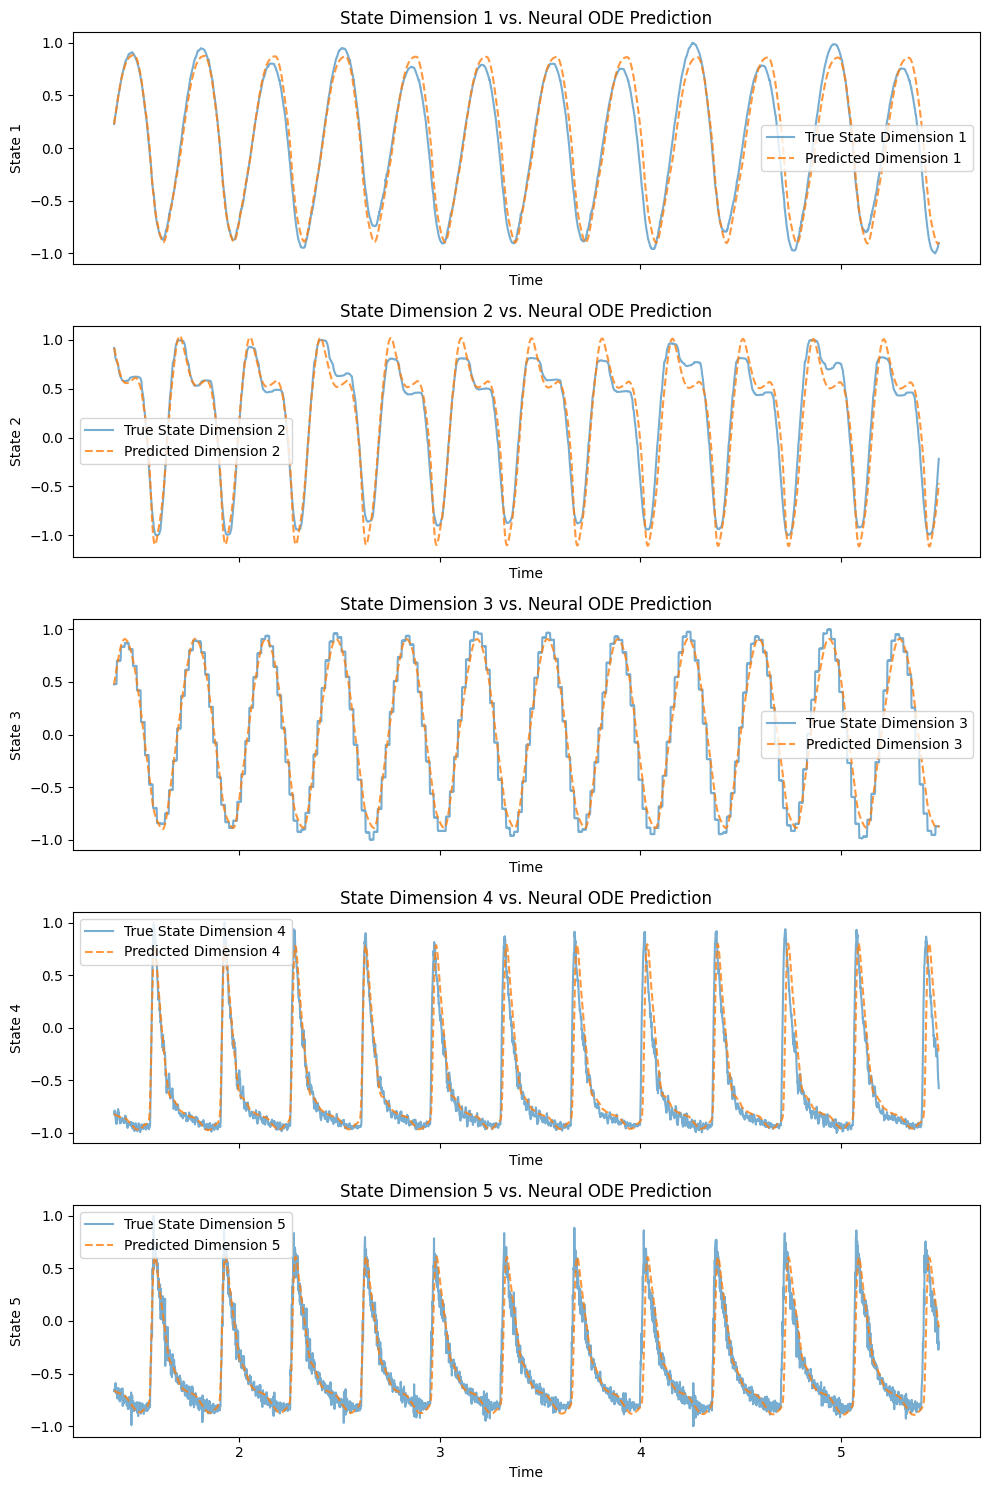

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure `ts` and `ys` are loaded from the MATLAB file with the correct dimensions.
# ts is the time array, ys is of shape (1, length_size, 5).

# Define the model structure with the same parameters used during training
data_size = 5  # Dimensionality of the input state
width_size = 32
depth = 6
key = jr.PRNGKey(0)  # Replace with the seed or key you used

# Initialize an empty model with the same structure
empty_model = NeuralODE(data_size, width_size=width_size, depth=depth, key=key)

# Load the trained parameters into the model structure
neural_ode_model = eqx.tree_deserialise_leaves("trained_neural_ode.eqx", empty_model)

# Define initial conditions for the Neural ODE (the first observation in the training set)
y0_initial = ys[0, 0, :]  # Initial state is the first observation (vector with 5 elements)

# Predict using the Neural ODE across the entire time range
neural_ode_predictions = neural_ode_model(ts, y0_initial)

# Convert predictions to numpy array for plotting
neural_ode_predictions = np.array(neural_ode_predictions)

# Create a figure with subplots for each state dimension
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# Plot each state dimension with its corresponding prediction
for i in range(5):
    axes[i].plot(ts, ys[0, :, i], label=f"True State Dimension {i+1}", alpha=0.6)
    axes[i].plot(ts, neural_ode_predictions[:, i], linestyle='--', label=f"Predicted Dimension {i+1}", alpha=0.8)
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel(f"State {i+1}")
    axes[i].legend()
    axes[i].set_title(f"State Dimension {i+1} vs. Neural ODE Prediction")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [63]:
import jax.numpy as jnp

def neural_ode_predict(model, ts, y0):
    """
    Predicts the output of the Neural ODE model over the time points `ts` given the initial state `y0`.
    
    Parameters:
    - model: The Neural ODE model.
    - ts: A 1D array of time points at which to predict the output.
    - y0: The initial state, should be a 1D or 2D array depending on the model.
    
    Returns:
    - A 2D array where each row corresponds to the model's output at a time point.
    """
    # Ensure y0 has the correct shape
    y0 = jnp.asarray(y0)
    if y0.ndim == 0:
        # If y0 is a scalar, make it a vector of the appropriate size.
        y0 = y0 * jnp.ones((model.func.layers[0].in_features,))
    elif y0.ndim == 1:
        # Ensure y0 matches the expected input size of the model
        y0 = y0.reshape((model.func.layers[0].in_features,))
    
    # Solve the Neural ODE using the diffrax solver
    solution = model(ts, y0)
    
    # Convert the solution to a numpy array for further processing (if necessary)
    return solution

Calling ODE solver with y0 shape: (5,) and ts shape: (1233,)
ODE solve completed: solution shape = (1233, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (2,)
ODE solve completed: solution shape = (2, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (2,)
ODE solve completed: solution shape = (2, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (3,)
ODE solve completed: solution shape = (3, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (2,)
ODE solve completed: solution shape = (2, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (3,)
ODE solve completed: solution shape = (3, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (2,)
ODE solve completed: solution shape = (2, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (3,)
ODE solve completed: solution shape = (3, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (2,)
ODE solve completed: solution shape = (2, 5)
Calling ODE solver with y0 shape: (5,) and ts shape: (3,)
ODE solve

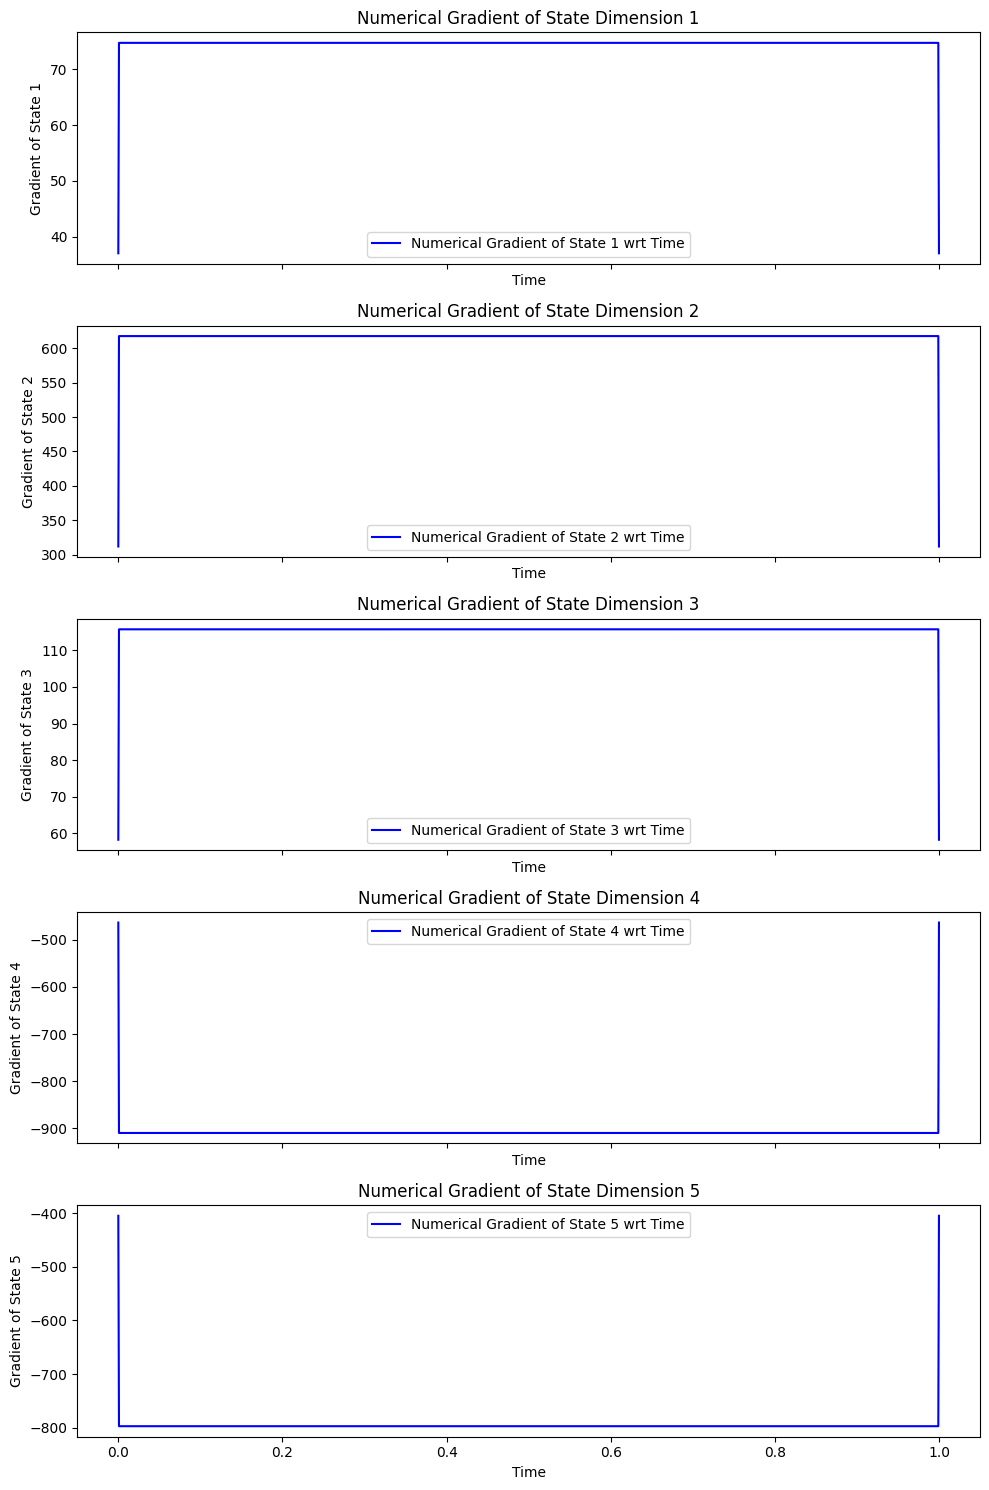

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to numerically approximate the gradient (dy/dt) using finite differences
def numerical_gradient(model, ts, y0, h=1e-5):
    """
    Computes the numerical gradient of the Neural ODE output with respect to time using finite differences.

    Parameters:
    - model: The Neural ODE model.
    - ts: The time points to evaluate.
    - y0: The initial conditions for the ODE.
    - h: The small step size for finite differences.

    Returns:
    - gradients: An array of gradients for each dimension of the Neural ODE output.
    """
    # Get the predictions at time ts
    y_pred = neural_ode_predict(model, ts, y0)
    gradients = []

    # Compute gradient using finite differences for each time point
    for i, t in enumerate(ts):
        # Define forward and backward time ranges with a minimum of 2 points
        t_forward = ts[max(0, i - 1): min(i + 2, len(ts))]
        t_backward = ts[max(0, i - 1): min(i + 1, len(ts))]
        
        # If there's only one point in the forward or backward range, add another point
        if len(t_forward) == 1:
            t_forward = np.append(t_forward, t_forward[0] + h)
        if len(t_backward) == 1:
            t_backward = np.append(t_backward, t_backward[0] - h)

        # Solve ODE for forward and backward steps
        y_forward = neural_ode_predict(model, t_forward, y0)
        y_backward = neural_ode_predict(model, t_backward, y0)

        # Calculate the gradient for each state dimension using central difference
        gradient = (y_forward[-1] - y_backward[0]) / (2 * h)
        gradients.append(gradient)

    return np.array(gradients)

# Adjust the initial condition to have the correct shape (5 dimensions)
y0_initial = np.array([y_train[:5]])  # Select the first 5 values of y_train as the initial state

# If y_train has only 1 value per time point, you might need to adjust it like this:
# y0_initial = np.tile(y_train[:1], (5,))  # Repeat the first value 5 times to match the 5-dimensional shape

# Generate time series for training (unscaled time points)
ts_train = np.linspace(0, 1, len(X_train))  # Use the unscaled time

# Compute the numerical gradient using the corrected initial conditions
gradients = numerical_gradient(neural_ode_model, ts_train, y0_initial)


# Visualize the gradient for each state dimension
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

for i in range(5):
    axes[i].plot(ts_train, gradients[:, i], label=f"Numerical Gradient of State {i+1} wrt Time", color='blue')
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel(f"Gradient of State {i+1}")
    axes[i].set_title(f"Numerical Gradient of State Dimension {i+1}")
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Calling ODE solver with y0 shape: (5,) and ts shape: (2,)
ODE solve completed: solution shape = (2, 5)
y0_t0 shape: (5,)
gradients_t0 shape: (5,)
t_eval shape: (1233,)
t0: 0.0, y0 shape: (5,), gradients shape: (5,)
delta_t shape: (1233,), taylor_approx shape: (1233, 5)
Order 1: gradient shape: (), term shape: (1233, 1)
Final taylor_approx shape: (1233, 5)


/var/folders/n4/zjd0h9l56bb9c6pjr7j5h3nm0000gn/T/ipykernel_13731/1167569495.py:25: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  term = np.outer(delta_t ** n, gradient) / np.math.factorial(n)


Plotting Neural ODE predictions for state dimension 1: shape = (1233,)
Plotting Taylor series approximation for state dimension 1: shape = (1233,)
Plotting Neural ODE predictions for state dimension 2: shape = (1233,)
Plotting Taylor series approximation for state dimension 2: shape = (1233,)
Plotting Neural ODE predictions for state dimension 3: shape = (1233,)
Plotting Taylor series approximation for state dimension 3: shape = (1233,)
Plotting Neural ODE predictions for state dimension 4: shape = (1233,)
Plotting Taylor series approximation for state dimension 4: shape = (1233,)
Plotting Neural ODE predictions for state dimension 5: shape = (1233,)
Plotting Taylor series approximation for state dimension 5: shape = (1233,)


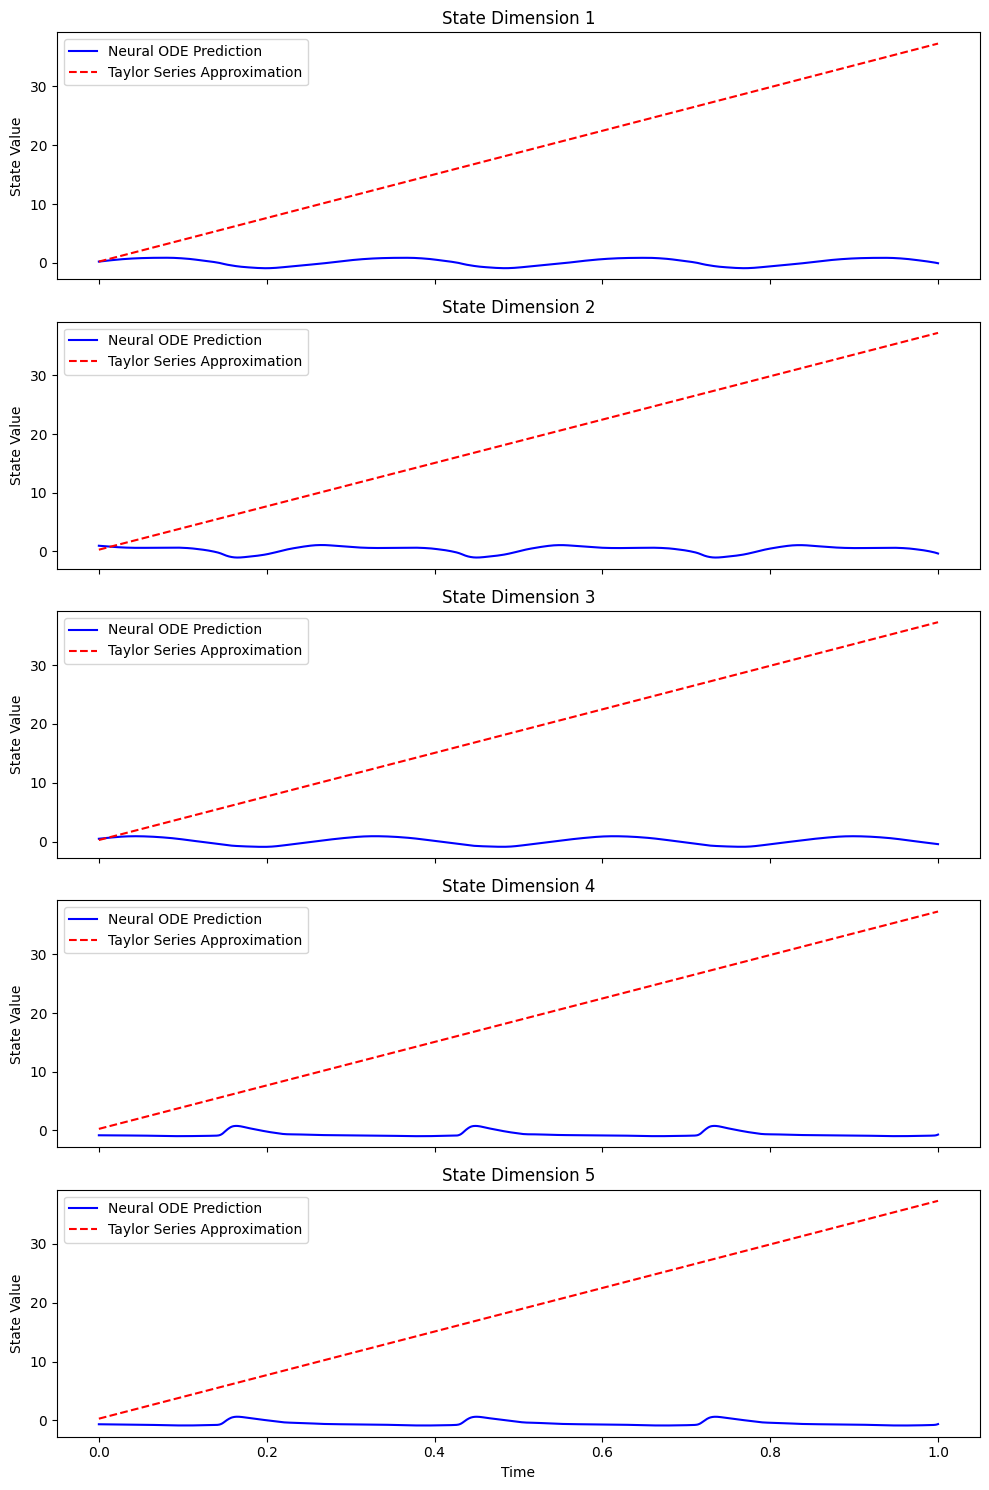

In [81]:
# Define a function for Taylor series approximation
def taylor_series_approximation(t_eval, t0, y0, gradients, order=1):
    """
    Compute the Taylor series approximation of the Neural ODE at t0.

    Parameters:
    - t_eval: Time points where the approximation is evaluated.
    - t0: The time point around which the Taylor series is computed.
    - y0: The state values at t0 (initial condition).
    - gradients: The gradients of the state values at t0.
    - order: The order of the Taylor series (default is 3).

    Returns:
    - taylor_approx: The Taylor series approximation at each time point in t_eval.
    """
    print(f"t_eval shape: {t_eval.shape}")
    print(f"t0: {t0}, y0 shape: {y0.shape}, gradients shape: {np.array(gradients).shape}")

    taylor_approx = np.tile(y0, (len(t_eval), 1))  # Initialize with y0 values and repeat for each time point
    delta_t = t_eval - t0  # Compute the time difference from t0 for each t_eval
    print(f"delta_t shape: {delta_t.shape}, taylor_approx shape: {taylor_approx.shape}")

    # Add each gradient term to the Taylor series for each state dimension
    for n, gradient in enumerate(gradients[:order], start=1):
        term = np.outer(delta_t ** n, gradient) / np.math.factorial(n)
        print(f"Order {n}: gradient shape: {gradient.shape}, term shape: {term.shape}")
        taylor_approx += term
    
    print(f"Final taylor_approx shape: {taylor_approx.shape}")
    return taylor_approx

# Select a time point t0 and compute the corresponding y0 and gradients
t0 = ts_train[0]  # Start with the first time point for simplicity
t_small_range = np.array([t0, t0 + 0.01])  # A small time interval around t0

# Get the initial state y0 at t0 for the Neural ODE model
y0_t0 = neural_ode_predict(neural_ode_model, t_small_range, y0_initial)[0]  # Get prediction at t0
print(f"y0_t0 shape: {y0_t0.shape}")

# Use the first set of gradients as an approximation for the gradients at t0
gradients_t0 = gradients[0]  # Ensure this has the shape (5,)
print(f"gradients_t0 shape: {np.array(gradients_t0).shape}")

# Ensure the time points match for both the Neural ODE and the Taylor series approximation
t_eval = ts_train  # Use the same time points as in the training data (1233 points)
neural_ode_predictions = neural_ode_predictions[:len(t_eval)]  # Align shapes by truncating

# Evaluate the Taylor series approximation over t_eval
taylor_approximation = taylor_series_approximation(t_eval, t0, y0_t0, gradients_t0)

# Plot the Neural ODE predictions and Taylor approximation for comparison
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# Plot the data for each dimension separately
for i in range(5):
    # Neural ODE predictions for the selected state dimension
    print(f"Plotting Neural ODE predictions for state dimension {i+1}: shape = {neural_ode_predictions[:, i].shape}")
    print(f"Plotting Taylor series approximation for state dimension {i+1}: shape = {taylor_approximation[:, i].shape}")
    
    axes[i].plot(t_eval, neural_ode_predictions[:, i], label="Neural ODE Prediction", color='blue')
    axes[i].plot(t_eval, taylor_approximation[:, i], label="Taylor Series Approximation", color='red', linestyle='--')
    axes[i].set_title(f"State Dimension {i + 1}")
    axes[i].set_ylabel("State Value")
    axes[i].legend()

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [82]:
ts_train

array([0.00000000e+00, 8.11688312e-04, 1.62337662e-03, ...,
       9.98376623e-01, 9.99188312e-01, 1.00000000e+00])